In [34]:
""" Filter based on h3 hexagons mapped to polygons

aws emr add-steps --cluster-id <Your EMR cluster id> --steps Type=spark,Name=TestJob,Args=[--deploy-mode,cluster,--master,yarn,--conf,spark.yarn.submit.waitAppCompletion=true,s3a://your-source-bucket/code/pythonjob.py,s3a://your-source-bucket/data/data.csv,s3a://your-destination-bucket/test-output/],ActionOnFailure=CONTINUE
"""

from collections import namedtuple
import logging
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns


import pyproj

from geopy.distance import great_circle
import pandas as pd
import geopandas as gpd
import os

from datetime import timedelta, date, datetime
from statistics import *

from pyspark import SparkContext

from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import (
    StructType,
    LongType,
    MapType,
    StructField,
    IntegerType,
    StringType,
    DoubleType,
    TimestampType,
    ArrayType
)
import pyspark.sql.functions as F
from math import *
import time

from shapely.wkt import loads as wkt_loads
from shapely.geometry import Point, Polygon, shape
from shapely.ops import transform
import shapely

#from timezonefinder import TimezoneFinder

spark = (SparkSession.builder   
         .config("spark.driver.maxResultSize", "3g")
    .getOrCreate() 
        )

import matplotlib.pyplot as plt



#------
# parameters
#------

data_out = "s3://ipsos-dvd/bloomberg/data/"



In [2]:
from scipy.stats import f
critical_value = f.ppf(0.95, dfn=3, dfd=931)
critical_value


2.6144642376698664

## Calculate Long Dwells Per Visitor

In [2]:
advan = (sqlContext.read.format('com.databricks.spark.csv')
         .options(header='true', inferschema='true')
         .option('escape','"') # this is necessary because the fields contain "," as well but dont have quotes around them
         .load("s3://external-advan/monthly_patterns*"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
advan.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+----------+---------+-----------+--------------------+--------------------+------+-----------+--------------------+--------------------+---------+---------+---------------------+--------------------+-------------+--------------------+--------------+--------+---------------+------------+--------------------+----------------+------------------+----------------+--------------+----------------+------------------+--------------------+----------------+--------------------+------------------------+--------------------+-------------------------+------------------+------------+--------------------+----------------------+------------------------+--------------------+--------------------+--------------------+----------------------------------+----------------------------------------+------------------------------------------+-------------------

In [4]:
# filter on corporate offices
advan = advan.filter(advan.CATEGORY_TAGS.contains("Corporate Offices"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# Cast the string to a MapType and extract the value for the key '>240'
col = "BUCKETED_DWELL_TIMES"
advan = advan.withColumn(col, F.from_json(col, MapType(StringType(), IntegerType()))) \
       .withColumn("two_hour_dwell", F.col(col).getItem(">240"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
advan = advan.withColumn("long_dwells_per_visitor", F.col("two_hour_dwell") / F.col("raw_visitor_counts"))


                     
                     

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
advan = advan.cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
advan = advan.select("long_dwells_per_visitor", "two_hour_dwell", "raw_visitor_counts", "placekey", 
                     "safegraph_brand_ids", "location_name", "brands", "latitude", "longitude", "city", "region", "postal_code",
                     "category_tags", "opened_on", "closed_on", "polygon_wkt", "raw_visit_counts", "poi_cbg", 
                    "date_range_start")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
advan.write.mode("overwrite").parquet(data_out + "advan_dwells_wfh")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Aggregate by city and plot time series

In [9]:
advan = spark.read.parquet(data_out + "advan_dwells_wfh")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
df = (advan.groupBy("city", "date_range_start")
            .agg(F.avg("long_dwells_per_visitor").alias("long_dwells_per_visitor"))
        ).toPandas()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
df.to_csv(data_out + "long_dwells_by_city.csv", header=True, index=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
df = pd.read_csv("/Users/davidvandijcke/Downloads/long_dwells_by_city.csv")

In [25]:
df['date_range_start'] = pd.to_datetime(df['date_range_start'])

In [45]:
top_100_cities = [
    'New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix',
    'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'San Jose',
    'Austin', 'Jacksonville', 'Fort Worth', 'Columbus', 'Charlotte',
    'San Francisco', 'Indianapolis', 'Seattle', 'Denver', 'Washington',
    'Boston', 'El Paso', 'Nashville', 'Detroit', 'Oklahoma City',
    'Portland', 'Las Vegas', 'Memphis', 'Louisville', 'Baltimore',
    'Milwaukee', 'Albuquerque', 'Tucson', 'Fresno', 'Sacramento',
    'Mesa', 'Kansas City', 'Atlanta', 'Long Beach', 'Omaha',
    'Raleigh', 'Colorado Springs', 'Miami', 'Virginia Beach', 'Oakland',
    'Minneapolis', 'Tulsa', 'Arlington', 'New Orleans', 'Wichita',
    'Cleveland', 'Tampa', 'Bakersfield', 'Aurora', 'Anaheim',
    'Honolulu', 'Santa Ana', 'Corpus Christi', 'Riverside', 'St. Louis',
    'Lexington', 'Stockton', 'Pittsburgh', 'Saint Paul', 'Anchorage',
    'Cincinnati', 'Henderson', 'Greensboro', 'Plano', 'Newark',
    'Toledo', 'Lincoln', 'Orlando', 'Chula Vista', 'Jersey City',
    'Chandler', 'Fort Wayne', 'Buffalo', 'Durham', 'St. Petersburg',
    'Irvine', 'Laredo', 'Lubbock', 'Madison', 'Gilbert',
    'Norfolk', 'Reno', 'Winston–Salem', 'Glendale', 'Hialeah',
    'Garland', 'Scottsdale', 'Irving', 'Chesapeake', 'North Las Vegas',
    'Fremont', 'Baton Rouge', 'Richmond', 'Boise', 'San Bernardino'
]


In [46]:
# Filter the data to only include records from the year 2019
df_2019 = df[df['date_range_start'].dt.year == 2019]

# Calculate the average 'long_dwells_per_visitor' for each city in 2019
avg_2019 = df_2019.groupby('city')['long_dwells_per_visitor'].mean().reset_index()

# Rename the column to 'avg_2019'
avg_2019.columns = ['city', 'avg_2019']

# Merge this average back into the main dataframe
df_merged = pd.merge(df, avg_2019, on='city', how='left')

# Calculate the new measure: monthly 'long_dwells_per_visitor' divided by the 2019 average for each city
df_merged['normalized_long_dwells'] = (df_merged['long_dwells_per_visitor'] / df_merged['avg_2019']) * 100

# Count the number of records for each city to approximate its size (larger cities should have more records)
city_counts = df['city'].value_counts()


# Filter the dataframe to only include the top 100 cities
df_merged_top_100 = df_merged[df_merged['city'].isin(top_100_cities)]


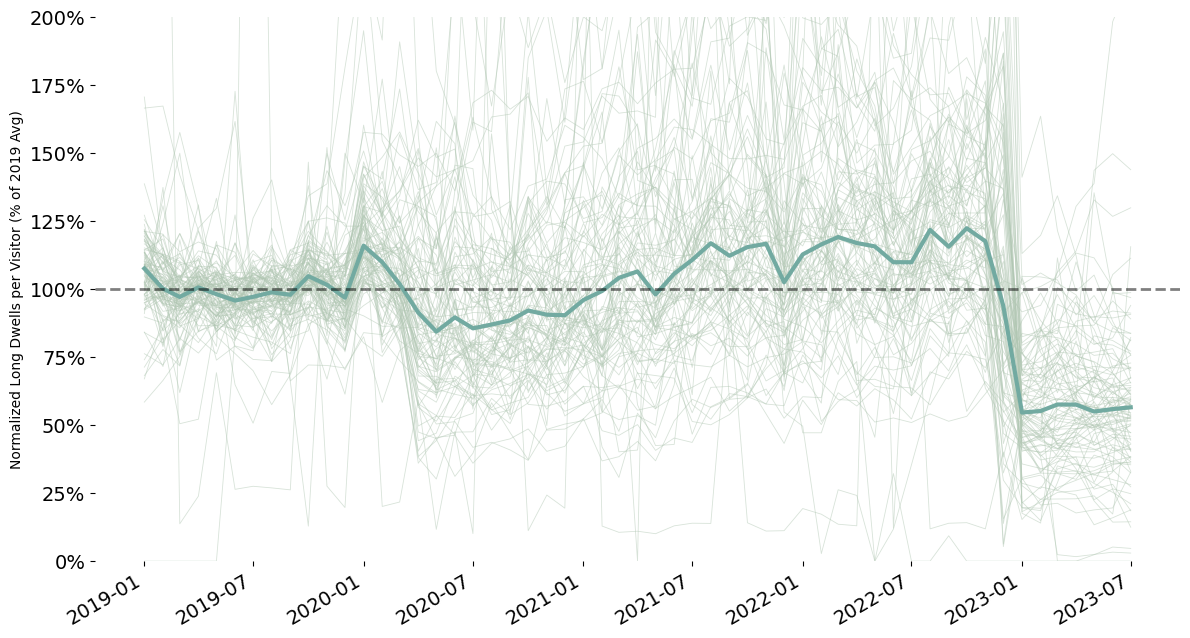

23/08/31 02:16:56 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 958005 ms exceeds timeout 120000 ms
23/08/31 02:16:56 WARN SparkContext: Killing executors is not supported by current scheduler.
23/08/31 02:33:53 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:103)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:87)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:643)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1057)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:238)
	at sc

In [49]:

# Create the plot for the normalized measure for the top 100 cities
fig, ax = plt.subplots(figsize=(14, 8))

# Loop through each unique city in the top 100 list to plot its normalized time series
for city in top_100_cities:
    temp = df_merged_top_100[df_merged_top_100['city'] == city]
    temp.plot(x='date_range_start', y='normalized_long_dwells', ax=ax, label=city, linewidth=0.6, color="#b1c7b3", legend=False, alpha=0.5)

# Plotting the median time series across top 100 cities
df_merged_top_100.groupby('date_range_start').agg({'normalized_long_dwells': 'median'}).plot(ax=ax, color="#72aaa1", linewidth=3, legend=False)

# Adding a horizontal line
plt.axhline(y=100, color='black', linestyle='--', linewidth=2, alpha=0.5)

# Setting labels and other aesthetics
plt.xlabel("")
plt.ylabel("Normalized Long Dwells per Visitor (% of 2019 Avg)")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.ylim([0,200])

plt.show()


In [44]:
df['city']

0         Ballenger Creek
1               Palo Alto
2                  Iselin
3              Burlington
4                 Lebanon
               ...       
140131              Ozone
140132             Lorain
140133         Grove Hill
140134        Chibougamau
140135      Windsor Locks
Name: city, Length: 140136, dtype: object